# Online retail

Link to the dataset: http://archive.ics.uci.edu/ml/datasets/Online+Retail


This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Attribute Information:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 
- UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal, the name of the country where each customer resides.


Relevant Papers:

- The evolution of direct, data and digital marketing, Richard Webber, Journal of Direct, Data and Digital Marketing Practice (2013) 14, 291â€“309. 
- Clustering Experiments on Big Transaction Data for Market Segmentation, 
- Ashishkumar Singh, Grace Rumantir, Annie South, Blair Bethwaite, Proceedings of the 2014 International Conference on Big Data Science and Computing. 
- A decision-making framework for precision marketing, Zhen You, Yain-Whar Si, Defu Zhang, XiangXiang Zeng, Stephen C.H. Leung c, Tao Li, Expert Systems with Applications, 42 (2015) 3357â€“3367.

## 1) Data discovery & cleaning

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 

import matplotlib.pyplot as plt
FIGSIZE = (12.0, 5.0)
plt.rcParams['figure.figsize'] = (12.0, 5.0)

pd.options.display.max_rows = 55
pd.options.display.max_colwidth = 500


In [2]:
link = 'Online Retail.xlsx'

In [3]:
xl = pd.ExcelFile(link)

for sheet in xl.sheet_names[1:]:
    print(xl.parse(sheet).columns[0])

In [4]:
on = pd.ExcelFile(link)

# Print the sheet names
#print(on.sheet_names)

In [5]:
# Load a sheet into a DataFrame by name: df1
online = on.parse('Online Retail')

In [6]:
online.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
online.shape

(541909, 8)

In [8]:
#Checking null values
online.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are 135080 CustomerID´s missing out of 541909. The analysis is based on customers, then let´s remove these rows from the dataframe. 

In [9]:
online = online[pd.notnull(online['CustomerID'])]

In [10]:
# Check the minimum values in UnitPrice and Quantity columns.

online.Quantity.min() 
# THe result is a negative value, which is impossible. 

#Only positive quantities
online = online[(online['Quantity']>0)]
online.shape


(397924, 8)

#### Grouping by country 

Customer clusters can vary by geography. Most of customers come from the UK with 3950 customers, the second biggest market is Germany with only 95 customers. It makes sense to select only customers from the UK, but for now let´s keep on all the data.

In [11]:
#Grouping by country. 
customer_country= online[['Country','CustomerID']].drop_duplicates()

customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3921
14,Germany,94
13,France,87
30,Spain,30
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,14
12,Finland,12
1,Austria,11


#### Check unique value for all columns

In [12]:
def unique_counts(columns):
   for i in online.columns:
       count = online[i].nunique()
       print(i, ": ", count)
unique_counts(online)

InvoiceNo :  18536
StockCode :  3665
Description :  3877
Quantity :  302
InvoiceDate :  17286
UnitPrice :  441
CustomerID :  4339
Country :  37


## 2) Cohort Analysis

Let´s compare metrics across customer lifecycle, using 'CohortMonth' as the time the customer bought something for the first time.

In [13]:
import datetime as dt
from datetime import datetime

In [14]:
# Define a function that will parse the date
def get_month(x): return dt.datetime(x.year, x.month, 1) 

# Create InvoiceMonth column
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month) 

# Group by CustomerID and select the InvoiceMonth value
grouping = online.groupby('CustomerID')['InvoiceMonth'] 

# Assign a minimum InvoiceMonth value to the dataset
online['CohortMonth'] = grouping.transform('min')

# View the top 5 rows
online.shape

(397924, 10)

In [15]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [16]:
# Get the integers for date parts from the `InvoiceMonth` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceMonth')

# Get the integers for date parts from the `CohortMonth` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortMonth')

Apply time offset value calculating the difference between the Invoice and Cohort dates in years, months and days.

In [17]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
online['CohortIndexdays'] = years_diff * 365 + months_diff * 30 + days_diff + 1

# Extract the difference in months  from all previous values
online['CohortIndex'] = years_diff * 365 + months_diff * 30 + 1

online.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndexdays,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,1


It will be complicated to perform metrics if we cannot identify the customer. There are 135080 missing Customer ID out of 541909.

### Customer retention metric

Let's count monthly active customers from each cohort. The amount of costumers during the first month is the size of the cohort. 

In [18]:
grouping = online.groupby(['CohortMonth','CohortIndex'])

# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index().sort_values(by=['CustomerID'])

cohort_data.head()

,CohortMonth,CohortIndex,CustomerID
80,2011-08-01,121,21
75,2011-07-01,151,21
54,2011-04-01,241,22
69,2011-06-01,181,23
35,2011-02-01,301,26


In [19]:
# Create a pivot to see the active customers per cohort. Recent cohorts will have more NaN.
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

cohort_counts.head(3)

CohortIndex,1,31,36,61,66,91,96,121,126,151,...,216,241,246,271,276,301,306,331,336,366
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-12-01,885.0,NaN,324.0,NaN,286.0,NaN,340.0,NaN,321.0,NaN,...,309.0,NaN,313.0,NaN,350.0,NaN,331.0,NaN,445.0,235.0
2011-01-01,417.0,92.0,NaN,111.0,NaN,96.0,NaN,134.0,NaN,120.0,...,NaN,125.0,NaN,136.0,NaN,152.0,NaN,49.0,NaN,NaN
2011-02-01,380.0,71.0,NaN,71.0,NaN,108.0,NaN,103.0,NaN,94.0,...,NaN,94.0,NaN,116.0,NaN,26.0,NaN,NaN,NaN,NaN


In [20]:
#The amount of costumers during the first month is the reference size of the cohort. 

cohort_sizes = cohort_counts.iloc[:,0]

cohort_sizes

CohortMonth
2010-12-01    885.0
2011-01-01    417.0
2011-02-01    380.0
2011-03-01    452.0
2011-04-01    300.0
2011-05-01    284.0
2011-06-01    242.0
2011-07-01    188.0
2011-08-01    169.0
2011-09-01    299.0
2011-10-01    358.0
2011-11-01    324.0
2011-12-01     41.0
Name: 1, dtype: float64

In [21]:
#What does axis=0 mean again? 

#Retention rate in %
retention = cohort_counts.divide(cohort_sizes, axis=0).round(3)*100

retention.head()

CohortIndex,1,31,36,61,66,91,96,121,126,151,...,216,241,246,271,276,301,306,331,336,366
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-12-01,100.0,NaN,36.6,NaN,32.3,NaN,38.4,NaN,36.3,NaN,...,34.9,NaN,35.4,NaN,39.5,NaN,37.4,NaN,50.3,26.6
2011-01-01,100.0,22.1,NaN,26.6,NaN,23.0,NaN,32.1,NaN,28.8,...,NaN,30.0,NaN,32.6,NaN,36.5,NaN,11.8,NaN,NaN
2011-02-01,100.0,18.7,NaN,18.7,NaN,28.4,NaN,27.1,NaN,24.7,...,NaN,24.7,NaN,30.5,NaN,6.8,NaN,NaN,NaN,NaN
2011-03-01,100.0,15.0,NaN,25.2,NaN,19.9,NaN,22.3,NaN,16.8,...,NaN,27.9,NaN,8.6,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,100.0,21.3,NaN,20.3,NaN,21.0,NaN,19.7,NaN,22.7,...,NaN,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


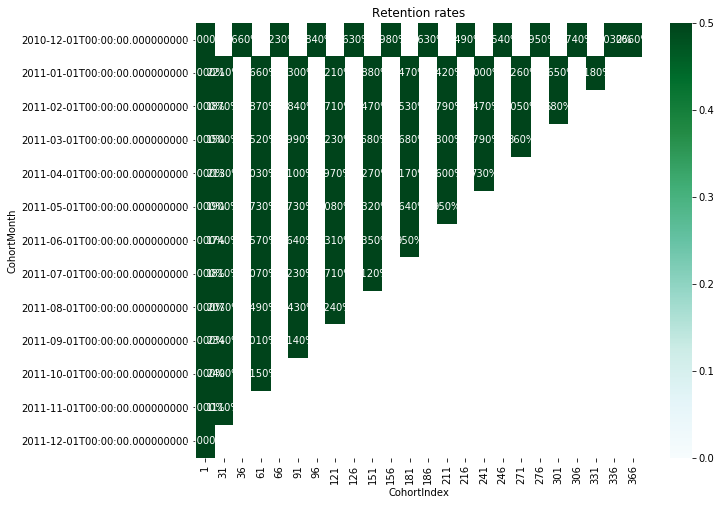

In [22]:
plt.figure(figsize=(10, 8))
plt.title('Retention rates')

sns.heatmap(data = retention, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0, 
            vmax = 0.5, 
            cmap = 'BuGn')

plt.show()

### Average quantity per cohort

In [23]:
online.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndexdays,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,1


In [24]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

cohort_data = grouping['Quantity'].mean()

cohort_data.head()

CohortMonth  CohortIndex
2010-12-01   1              11.937309
             36             15.573349
             66             15.593027
             96             15.759673
             126            13.505140
Name: Quantity, dtype: float64

In [25]:
cohort_data = cohort_data.reset_index()

cohort_data.head()

,CohortMonth,CohortIndex,Quantity
0,2010-12-01,1,11.937309
1,2010-12-01,36,15.573349
2,2010-12-01,66,15.593027
3,2010-12-01,96,15.759673
4,2010-12-01,126,13.505140


In [26]:
average_quantity = cohort_data.pivot(index='CohortMonth', 
                                     columns='CohortIndex', 
                                     values='Quantity')

average_quantity = average_quantity.round(1)

average_quantity.head()

CohortIndex,1,31,36,61,66,91,96,121,126,151,...,216,241,246,271,276,301,306,331,336,366
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-12-01,11.9,NaN,15.6,NaN,15.6,NaN,15.8,NaN,13.5,NaN,...,15.5,NaN,18.1,NaN,17.6,NaN,18.9,NaN,13.4,15.3
2011-01-01,17.2,13.3,NaN,12.6,NaN,15.1,NaN,12.8,NaN,15.3,...,NaN,11.6,NaN,10.5,NaN,9.5,NaN,10.0,NaN,NaN
2011-02-01,11.1,13.5,NaN,19.0,NaN,12.0,NaN,12.3,NaN,12.3,...,NaN,10.9,NaN,12.3,NaN,13.4,NaN,NaN,NaN,NaN
2011-03-01,9.9,11.7,NaN,13.3,NaN,10.1,NaN,14.3,NaN,13.0,...,NaN,11.2,NaN,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,10.0,10.4,NaN,9.8,NaN,11.8,NaN,11.8,NaN,8.6,...,NaN,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


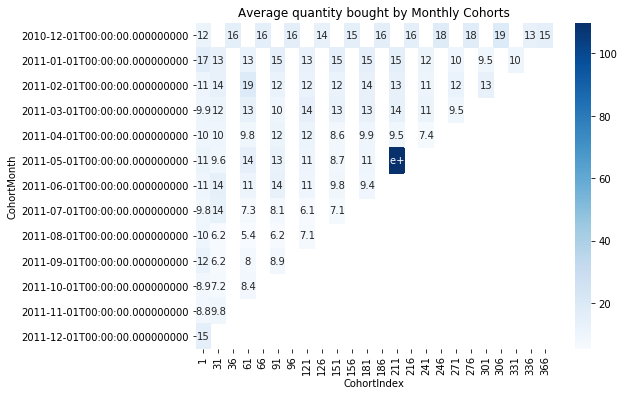

In [27]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

plt.title('Average quantity bought by Monthly Cohorts')

sns.heatmap(data=average_quantity, annot=True, cmap='Blues')
plt.show()

### Average unit price per cohort

In [28]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

cohort_dataunit= grouping['UnitPrice'].count().reset_index()

average_unitprice = cohort_dataunit.pivot(index='CohortMonth', 
                                     columns='CohortIndex', 
                                     values='UnitPrice')

average_unitprice = average_unitprice.round(1)

average_unitprice.head() 


CohortIndex,1,31,36,61,66,91,96,121,126,151,...,216,241,246,271,276,301,306,331,336,366
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-12-01,26160.0,NaN,10191.0,NaN,8777.0,NaN,11268.0,NaN,9728.0,NaN,...,11428.0,NaN,11417.0,NaN,14232.0,NaN,13545.0,NaN,22086.0,7254.0
2011-01-01,11041.0,2220.0,NaN,3039.0,NaN,2314.0,NaN,3627.0,NaN,3243.0,...,NaN,3793.0,NaN,5056.0,NaN,6398.0,NaN,1371.0,NaN,NaN
2011-02-01,8931.0,1412.0,NaN,1935.0,NaN,2505.0,NaN,2278.0,NaN,2027.0,...,NaN,2981.0,NaN,2946.0,NaN,451.0,NaN,NaN,NaN,NaN
2011-03-01,11458.0,1429.0,NaN,2609.0,NaN,2384.0,NaN,2445.0,NaN,2115.0,...,NaN,4297.0,NaN,996.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,7238.0,1405.0,NaN,1287.0,NaN,1301.0,NaN,1364.0,NaN,2038.0,...,NaN,523.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


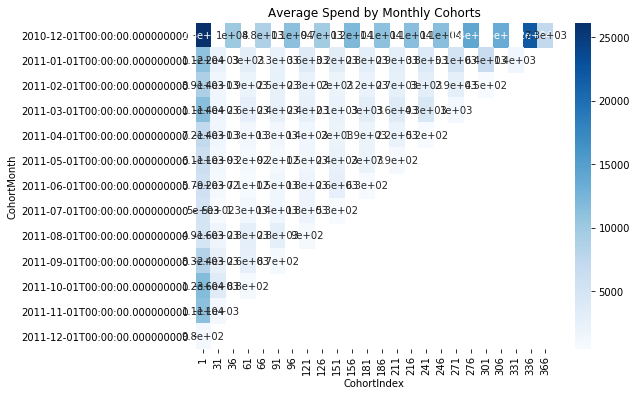

In [29]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

plt.title('Average Spend by Monthly Cohorts')

sns.heatmap(data=average_unitprice, annot=True, cmap='Blues')
plt.show()

## 3) RFM segmentation based on quartile values

###### 1) Monetary (series)

In [30]:
#Monetary 

online['spend'] = online['UnitPrice']*online['Quantity']  
money = online.groupby('CustomerID')['spend'].sum()

type(money)

pandas.core.series.Series

###### 2) Recency (series)

Since it has to be calculated from a point in time, we can use as a reference the last invoice date, which is 2011-12-09 plus one day, 2011-12-10. The first invoice in the data was on 2010-12-01.

In [31]:
 # Define a function that will parse the date
def get_day(x): return dt.datetime(x.year, x.month, x.day) 

# Create InvoiceMonth column
online['InvoiceDay'] = online['InvoiceDate'].apply(get_day) 

In [32]:
online['InvoiceDay'].min()
online['InvoiceDay'].max()

timeref =  dt.datetime(2011,12,10)

lastpurchase = online.groupby('CustomerID')['InvoiceDate'].max() 

recency = timeref - lastpurchase

type(recency)
recen = recency.to_frame(name=None).reset_index()

recen.rename(columns={'InvoiceDate': 'recency'}, inplace=True)

Creating recency labels

In [33]:
# Create string labels
r_labels = ['Active','Lapsed','Inactive','Churned']
# Divide into groups based on quartiles
recency_quartiles = pd.qcut(recen['recency'], q=4, labels=r_labels)
# Create new column
recen['Recency_Quartile'] = recency_quartiles
# Sort values from lowest to highest
recen.sort_values('recency')

,CustomerID,recency,Recency_Quartile
271,12680.0,0 days 11:10:00,Active
581,13113.0,0 days 11:11:00,Active
2543,15804.0,0 days 11:29:00,Active
1059,13777.0,0 days 11:35:00,Active
3824,17581.0,0 days 11:39:00,Active
326,12748.0,0 days 11:40:00,Active
297,12713.0,0 days 11:44:00,Active
144,12526.0,0 days 11:51:00,Active
3190,16705.0,0 days 11:52:00,Active
2177,15311.0,0 days 12:00:00,Active


In [34]:
#another way to have lastpurchase . It doesnt't work
#from datetime import timedelta
#snapshot_date = max(online.InvoiceDate) + datetime.timedelta(days=1)

###### 3) Frequency (series)

In [35]:
freq = online.groupby('CustomerID')['InvoiceNo'].count()

### RFM Table

In [36]:
rfmTable = online.groupby('CustomerID').agg({'InvoiceDate': lambda x: (timeref - x.max()).days,
                                             'InvoiceNo': lambda x: len(x), #'InvoiceNo': 'count'
                                             'spend': lambda x: x.sum()}) #'spend': 'sum'

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)

rfmTable.rename(columns={'InvoiceDate': 'recency',
                         'InvoiceNo': 'frequency',
                         'spend': 'monetary'}, inplace=True)

rfmTable.head(2)

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.6
12347.0,2,182,4310.0


### Quartiles

In [37]:
segmented_rfm2 = rfmTable

# Create labels for Recency (from low to high) and Frequency (this can be used to monetary as well)
r_labels = range(5, 0, -1); f_labels = range(1, 6)

# Assign these labels to three equal percentile groups 
r_groups = pd.qcut(segmented_rfm2['recency'], q=5, labels=r_labels)
f_groups = pd.qcut(segmented_rfm2['frequency'], q=5, labels=f_labels)
m_groups = pd.qcut(segmented_rfm2['monetary'], q=5, labels=f_labels)

# Create new columns R and F 
segmented_rfm2 = segmented_rfm2.assign(R=r_groups.values, F=f_groups.values, M= m_groups.values)

In [38]:
def join_rfm(x): 
    return str(x['R']) + str(x['F']) + str(x['M'])

segmented_rfm2['RFM_Segment'] = segmented_rfm2.apply(join_rfm, axis=1)
segmented_rfm2['RFM_Score'] = segmented_rfm2[['R','F','M']].sum(axis=1)


segmented_rfm2.head(2)#

,recency,frequency,monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,325,1,77183.6,1,1,5,115,7.0
12347.0,2,182,4310.0,5,5,5,555,15.0


## 4) Metrics per RFM Score


#### Size of the segments 

In [39]:
segments = segmented_rfm2.groupby('RFM_Segment').size().sort_values(ascending=False)[:5]

segments

RFM_Segment
555    306
111    271
455    164
122    150
211    127
dtype: int64

- Using 4 segments: The bigger segment has the lowes recency score (444) and the second biggest segment the highest recency score (111).
- Using 5 segments: Bigger segment 555 score, second biggest 111.

#### Top 10 customers 

In [40]:
segmented_rfm2[segmented_rfm2['RFM_Segment'] =='111'].sort_values('monetary', ascending=False).head(3)


,recency,frequency,monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
15510.0,330,1,250.0,1,1,1,111,3.0
16124.0,317,11,249.0,1,1,1,111,3.0
16510.0,372,13,248.1,1,1,1,111,3.0


#### Mean values

In [41]:
RFM = segmented_rfm2

RFM.head()

,recency,frequency,monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,325,1,77183.60,1,1,5,115,7.0
12347.0,2,182,4310.00,5,5,5,555,15.0
12348.0,75,31,1797.24,2,3,4,234,9.0
12349.0,18,73,1757.55,4,4,4,444,12.0
12350.0,310,17,334.40,1,2,2,122,5.0


In [42]:
RFM.groupby('RFM_Score').agg({'recency': 'mean','frequency': 'mean','monetary': ['mean','count'] }).round(1)

recency frequency monetary      
             mean      mean     mean count
RFM_Score                                 
3.0         278.6       7.0    138.6   271
4.0         200.1      11.0    201.9   260
5.0         182.7      16.6    294.0   374
6.0         122.7      19.3    373.9   378
7.0         104.7      27.0    902.0   385
8.0          86.7      36.9    627.4   373
9.0          69.8      46.9    894.6   356
10.0         57.7      62.1   1106.2   348
11.0         45.6      82.9   1972.4   332
12.0         33.5     110.4   1791.1   338
13.0         22.7     144.6   3185.7   317
14.0         14.7     231.4   4780.9   301
15.0          4.8     447.3  11686.9   306

#### RFM levels: Gold, silver, platinum and pink.

'RFM_Score' goes from 3 to 15. 

In [43]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 14:
        return 'Gold'
    elif ((df['RFM_Score'] >= 11) and (df['RFM_Score'] < 14)):
        return 'Silver'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 11)):
        return 'Bronce'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 8)):
          return 'Platinum'
    else:
        return 'Pink'

In [44]:
# Create a new variable RFM_Level
RFM['RFM_level'] = RFM.apply(rfm_level, axis=1)

RFM.head(5)

,recency,frequency,monetary,R,F,M,RFM_Segment,RFM_Score,RFM_level
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,1,1,5,115,7.0,Platinum
12347.0,2,182,4310.00,5,5,5,555,15.0,Gold
12348.0,75,31,1797.24,2,3,4,234,9.0,Bronce
12349.0,18,73,1757.55,4,4,4,444,12.0,Silver
12350.0,310,17,334.40,1,2,2,122,5.0,Platinum


In [45]:
#The last column gives the size of the level

RFM.groupby('RFM_level').agg({'recency': 'mean','frequency': 'mean','monetary': ['mean','sum'] }).round(1)

recency frequency monetary           
             mean      mean     mean        sum
RFM_level                                      
Bronce       71.7      48.3    870.4   937457.9
Gold          9.7     340.2   8262.3  5015245.6
Pink        240.2       9.0    169.6    90064.5
Platinum    136.4      21.0    526.4   598531.3
Silver       34.1     112.1   2300.0  2270108.7

In [46]:
RFM.describe()

,recency,frequency,monetary,RFM_Score
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,92.041484,91.708689,2053.793018,8.985250
std,100.007757,228.792852,8988.248381,3.589245
min,0.000000,1.000000,0.000000,3.000000
25%,17.000000,17.000000,307.245000,6.000000
50%,50.000000,41.000000,674.450000,9.000000
75%,141.500000,100.000000,1661.640000,12.000000
max,373.000000,7847.000000,280206.020000,15.000000


#### RFM visualization 

C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


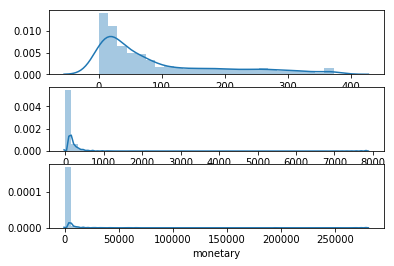

In [47]:
# Plot distributions 
plt.subplot(3, 1, 1); sns.distplot(RFM['recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM['frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM['monetary'])

# Show the plot
plt.show()

It is obvious from the result that frequency and monetary are very skewed. We apply logarithmic.

There is an anomaly in 'monet_log'.

In [154]:
#We need to change 'monet_log'. Apparently it has negative values
#Checking null values

#df.dropna(subset=['name', 'born'])
#RFM['monetary'].dropna(inplace=True)
RFM.isnull().sum()
RFM.isna().sum()

recency        0
frequency      0
monetary       0
R              0
F              0
M              0
RFM_Segment    0
RFM_Score      0
RFM_level      0
freq_log       0
monet_log      0
dtype: int64

In [160]:
# Apply log transformation and unskewing.
RFM['freq_log'] = np.log(RFM['frequency'])
RFM['monet_log'] = np.log(RFM['monetary'])
RFM['monet_log'] = RFM[RFM['monet_log']>0]

#RFM.dropna(subset=['monet_log'], axis = 0 , inplace= True)

RFM.dropna(axis = 0 , inplace= True)

RFM.head()

,recency,frequency,monetary,R,F,M,RFM_Segment,RFM_Score,RFM_level,freq_log,monet_log
CustomerID,,,,,,,,,,,
12346.0,325,1,77183.60,1,1,5,115,7.0,Platinum,0.000000,325
12347.0,2,182,4310.00,5,5,5,555,15.0,Gold,5.204007,2
12348.0,75,31,1797.24,2,3,4,234,9.0,Bronce,3.433987,75
12349.0,18,73,1757.55,4,4,4,444,12.0,Silver,4.290459,18
12350.0,310,17,334.40,1,2,2,122,5.0,Platinum,2.833213,310


In [161]:
RFM['monet_log'] = RFM['monet_log'].astype(str).astype(float)

RFM.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 11 columns):
recency        4338 non-null int32
frequency      4338 non-null int64
monetary       4338 non-null float64
R              4338 non-null category
F              4338 non-null category
M              4338 non-null category
RFM_Segment    4338 non-null object
RFM_Score      4338 non-null float64
RFM_level      4338 non-null object
freq_log       4338 non-null float64
monet_log      4338 non-null float64
dtypes: category(3), float64(4), int32(1), int64(1), object(2)
memory usage: 301.0+ KB


C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


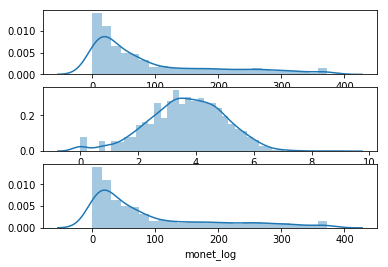

In [162]:
plt.subplot(3, 1, 1) ; sns.distplot(RFM['recency'])
plt.subplot(3, 1, 2) ; sns.distplot(RFM['freq_log'])
plt.subplot(3, 1, 3) ; sns.distplot(RFM['monet_log'])
plt.show()

## 5) K means clustering 

#### Giving the same mean and variance to each variable
Otherwise Kmeans do not work well.

Doing it by hand, obtaining RFM_norm dataset. 

In [163]:
justrfm = RFM[['recency', 'freq_log', 'monet_log']]

# Normalize the data by applying both centering and scaling
RFM_norm = (justrfm - justrfm.mean())/ justrfm.std()

RFM_norm.describe().round(2)

,recency,freq_log,monet_log
count,4338.00,4338.00,4338.00
mean,-0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-0.92,-2.78,-0.92
25%,-0.75,-0.64,-0.75
50%,-0.42,0.03,-0.42
75%,0.50,0.70,0.50
max,2.81,3.99,2.81


*The same*  but using a scaler, obtaining rfm_norm dataset.

In [176]:
from sklearn.preprocessing import StandardScaler

# Initialize a scaler
scaler = StandardScaler()
scaler.fit(justrfm)

rfm_norm = scaler.transform(justrfm)
#print('mean: ', rfm_norm.mean(axis=0).round(2))
#print('std: ', rfm_norm.std(axis=0).round(2))

rfm_norm1 = pd.DataFrame(rfm_norm, index=justrfm.index, columns=justrfm.columns)

# Print summary statistics
rfm_norm

array([[ 2.32938811, -2.77570919,  2.32938811],
       [-0.90058811,  1.14957291, -0.90058811],
       [-0.17059349, -0.18551873, -0.17059349],
       ...,
       [-0.85058848, -0.90139193, -0.85058848],
       [-0.89058819,  2.22369487, -0.89058819],
       [-0.50059106,  0.42884901, -0.50059106]])

*Same stuff but in one sequence* : 1) Log, 2) normalization, 3) storing a new df: RFM2.

In [54]:
justrfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
recency      4338 non-null int32
frequency    4338 non-null int64
monetary     4338 non-null float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 118.6 KB


In [126]:
just = RFM[['frequency', 'recency', 'monetary']]

just = just[just >= 1]
just.dropna(axis = 0 , inplace= True)
#just.dropna(subset=['monetary'], axis = 0 , inplace= True)

#just['monetary'] = pd.to_numeric(just['monetary'])
#just['monetary'] = just['monetary'].astype(str).astype(int)
just.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4303 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
frequency    4303 non-null int64
recency      4303 non-null float64
monetary     4303 non-null float64
dtypes: float64(2), int64(1)
memory usage: 134.5 KB


In [119]:
just.head()

,frequency,recency,monetary
CustomerID,,,
12346.0,1,325.0,77183.60
12347.0,182,2.0,4310.00
12348.0,31,75.0,1797.24
12349.0,73,18.0,1757.55
12350.0,17,310.0,334.40


In [120]:
for j in just['recency']:
    try:
        np.log(j)
    except:
        print(j)

In [139]:
#IT DOEsn't run now. ValueError: Input contains NaN, infinity or a value too large for dtype('float64')

#First | log 
rfm_log = np.log(just)

#Second | normalization with a scaler
#It doesn't work. ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

scaler.fit(rfm_log)

#Third | saving in a new df
RFM2 = scaler.transform(rfm_log)
RFM2 = pd.DataFrame(RFM2, index= just.index, columns = just.columns)

RFM2.head(1)

,frequency,recency,monetary
CustomerID,,,
12346.0,-2.779159,1.39902,3.757368


### Methods to define the number of clusters 

Elbow criterion, mathematical methods (silhouette coefficients), experimentation and interpretation.

In [101]:
# Import KMeans 
from sklearn.cluster import KMeans

#### Elbow criterion method

In [165]:
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
     
    # Fit KMeans on the normalized dataset
    kmeans.fit(RFM_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

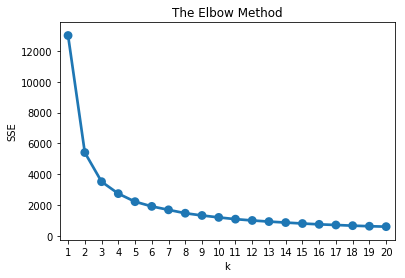

In [166]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

We can select elbow 4.

In [177]:
#Original dataset
just.head()

# Normalized array
rfm_norm

#Normalized dataset
RFM_norm.head()

,recency,freq_log,monet_log
CustomerID,,,
12346.0,2.329120,-2.775389,2.329120
12347.0,-0.900484,1.149440,-0.900484
12348.0,-0.170574,-0.185497,-0.170574
12349.0,-0.740504,0.460449,-0.740504
12350.0,2.179138,-0.638597,2.179138


I will forget the logarithmic

In [219]:
# Normalize the data by applying both centering and scaling
just_norm = (justrfm - justrfm.mean())/ justrfm.std()

just_norm.describe().round(2)

just_norm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
recency      4338 non-null float64
freq_log     4338 non-null float64
monet_log    4338 non-null float64
dtypes: float64(3)
memory usage: 135.6 KB


##### Doubt: The thing that works is to fit the original dataframe instead of the normalized dataframe.

In [217]:
# Initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(just_norm)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [218]:
# Create a DataFrame by adding a new cluster label column to the ORIGINAL dataframe

df_cluster = df_cluster.assign(cluster = cluster_labels)


ValueError: Length of values does not match length of index

In [212]:
df_cluster.groupby(['cluster']).agg({'recency': 'mean',     
                                   'frequency': 'mean',     
                                   'monetary': ['mean', 'count'], }).round(0) 

recency frequency  monetary      
           mean      mean      mean count
cluster                                  
0          95.0      77.0    1200.0  4194
1          29.0    1307.0   77493.0    15
2          20.0     449.0   16432.0    92
3           4.0    1208.0  237378.0     2

In [213]:
#Three clusters
kmeans = KMeans(n_clusters=3, random_state=1) 
kmeans.fit(just)

cluster_labels = kmeans.labels_
df_cluster3 = df_cluster.assign(cluster = cluster_labels)
df_cluster3.groupby(['cluster']).agg({'recency': 'mean',     
                                   'frequency': 'mean',     
                                   'monetary': ['mean', 'count'], }).round(0) 

recency frequency  monetary      
           mean      mean      mean count
cluster                                  
0          93.0      82.0    1413.0  4271
1           9.0    2042.0  172175.0     5
2          34.0     867.0   47625.0    27

In [214]:
#Five clusters
kmeans = KMeans(n_clusters=5, random_state=1) 
kmeans.fit(just)

cluster_labels = kmeans.labels_
df_cluster3 = df_cluster.assign(cluster = cluster_labels)
df_cluster3.groupby(['cluster']).agg({'recency': 'mean',     
                                   'frequency': 'mean',     
                                   'monetary': ['mean', 'count'], }).round(0) 

recency frequency  monetary      
           mean      mean      mean count
cluster                                  
0          97.0      69.0    1027.0  4065
1          10.0    2032.0  145168.0     4
2          42.0     999.0   53252.0    21
3          22.0     348.0    9557.0   212
4           1.0    2080.0  280206.0     1

Snake plot


In [220]:
 Melt the normalized dataset and reset the index
datamart_melt = pd.melt(RFM2.reset_index(),
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                    var_name ='Metric', value_name ='Value')

SyntaxError: invalid syntax (<ipython-input-220-2ebd0c0fa16b>, line 1)

###### Another method for quartiles | The long way 

In [ ]:
geld = money.to_frame(name=None).reset_index() 

In [ ]:
# Create a spend quartile with 4 groups - a range between 1 and 5
spend_quartile = pd.qcut(geld['spend'], q=4, labels=range(1,5))

# Assign the quartile values to the Spend_Quartile column in data
geld['Spend_Quartile'] = spend_quartile

# Print data with sorted spend values
geld.sort_values('spend')

geld.Spend_Quartile.unique()

In [ ]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

segmented_rfm = rfmTable
segmented_rfm.head(2)

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary'].apply(FMScore, args=('monetary',quantiles,))

segmented_rfm.head(2)

In [ ]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)

segmented_rfm.head(4)